In [1]:
#import matplotlib.pyplot as plt
import pyamg
import numpy as np
from scipy.io import loadmat

import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.collections import LineCollection
from matplotlib.patches import Polygon

from matplotlib import rcParams, rc
import matplotlib.pylab as plt

fp = {'size': 32, 'family': 'serif', 'serif': ['Computer Modern']}
rc('font', **fp)
rc('text', usetex=True)

np.set_printoptions(precision=2)

import shapely.geometry as sg
from shapely.ops import cascaded_union

import descartes

%matplotlib inline

In [3]:
data = loadmat('square.mat')

A = data['A'].tocsr()                        # matrix
V = data['vertices'][:A.shape[0]]            # vertices of each variable
E = np.vstack((A.tocoo().row,A.tocoo().col)).T  # edges of the matrix graph
Elmts = data['elements']

print(V.shape)
print(E.shape)

#n=15
#A = pyamg.gallery.poisson((n,n), format='csr')
#V, Elmts = pyamg.gallery.mesh.regular_triangle_mesh(n,n)
#V = 2*V - 1
#E = []
#for e in Elmts:
#    E.append([e[0], e[1]])
#    E.append([e[1], e[2]])
#    E.append([e[2], e[0]])
#E = np.array(E)

#print(V.shape)
#print(E.shape)

(191, 2)
(1243, 2)


25


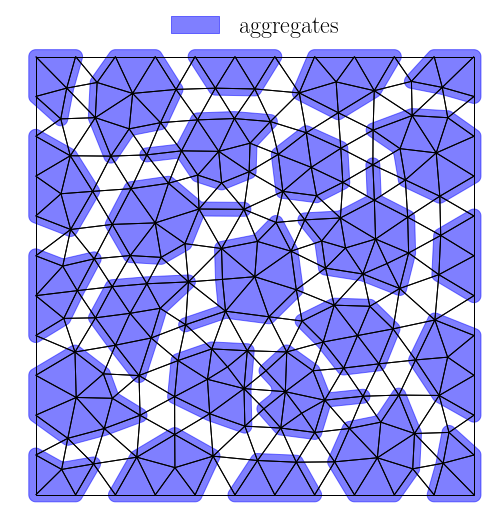

In [4]:
f, ax = plt.subplots(1, figsize=(8,8))
ax.set_xlim((-1.6, 1.6))
ax.set_ylim((-1.6, 1.6))

x = V[:,0]
y = V[:,1]
xstart = x[E[:,0]]
ystart = y[E[:,0]]
xend = x[E[:,1]]
yend = y[E[:,1]]
ls = []
for i in range(len(xstart)):
    ls.append([(xstart[i], ystart[i]), (xend[i], yend[i])])
ls = LineCollection(ls, linewidth=1, colors=['k'])
ax.add_collection(ls)
ax.set_aspect('equal', adjustable='box')
ax.axis('off')

# plot aggregates
mlSA = pyamg.smoothed_aggregation_solver(A, max_coarse=1, keep=True)
n = A.shape[0]
nagg = mlSA.levels[0].AggOp.shape[1]
AggOp = mlSA.levels[0].AggOp
print(nagg)
for i in range(nagg):
    J = AggOp.getcol(i).tocoo().row
    #print(J)
    #ax.plot(x[J], y[J], 'o')
    # check which nodes are in the group, which are tails
    G = np.zeros((len(J), len(J)))
    
    for j1 in range(len(J)):
        for j2 in range(len(J)):
            G[j1, j2] = int(bool(A[J[j1], J[j2]]))
            G[j2, j1] = int(bool(A[J[j2], J[j1]]))
    
    Gsum = G.sum(axis=0)
    Jtails = J[np.where(Gsum==2)[0]]
    Jint = J[np.where(Gsum!=2)[0]]
    
    # for each interior point, find the triangle
    tris = []
    for j in Jint:
        
        # find the elements
        K = np.where(Elmts==j)[0]

        # for each element see if the whole thing is in the aggregate
        for k in K:
            verts = Elmts[k,:]
            if len(np.intersect1d(verts, Jint))==3:
                tri = sg.Polygon([xy for xy in zip(x[verts], y[verts])])
                tris.append(tri)
    
    trisu = cascaded_union(tris)
    trisu = trisu.buffer(0.1)
    trisu = trisu.buffer(-0.05)
    
    if len(Jtails)>0:
        # for each tail make a ...tail
        for j in Jtails:
            for k in Jint:
                if A[j, k]:
                    jnbr = k
            line = sg.LineString([(x[j], y[j]), (x[jnbr], y[jnbr])])
            line = line.buffer(0.05)
       
        agg = cascaded_union([trisu, line])
        xs, ys = agg.exterior.xy
    else:
        xs, ys = trisu.exterior.xy
    ax.fill(xs, ys, alpha=0.5, color='b', clip_on=False)

plt.legend(['aggregates'], loc='upper center', bbox_to_anchor=(0.5, 1.13), frameon=False, fontsize=24)
plt.savefig('graph-aggregates.pdf', bbox_inches='tight')

51


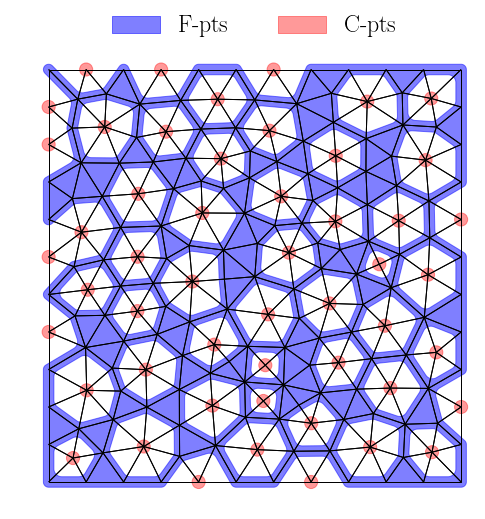

In [5]:
f, ax = plt.subplots(1, figsize=(8,8))
ax.set_xlim((-1.7, 1.7))
ax.set_ylim((-1.7, 1.7))

x = V[:,0]
y = V[:,1]
xstart = x[E[:,0]]
ystart = y[E[:,0]]
xend = x[E[:,1]]
yend = y[E[:,1]]
ls = []
for i in range(len(xstart)):
    ls.append([(xstart[i], ystart[i]), (xend[i], yend[i])])
ls = LineCollection(ls, linewidth=1, colors=['k'])
ax.add_collection(ls)
ax.set_aspect('equal', adjustable='box')
ax.axis('off')

mlCF = pyamg.ruge_stuben_solver(A, max_coarse=5, keep=True)
C = np.where(mlCF.levels[0].splitting==1)[0]
F = np.where(mlCF.levels[0].splitting==0)[0]
print(len(C))

if False:
    
    for j in C:
        ax.add_patch(mpatches.Circle((x[j], y[j]),0.05,color='b', alpha=0.4))
    
    h = 0.05
    for j in F:
        ax.add_patch(mpatches.Rectangle((x[j]-h, y[j]-h),2*h, 2*h,color='r', alpha=0.4))
    plt.savefig('graph-splitting.pdf', bbox_inches='tight')
    
lines = []
for i in range(A.shape[0]):
    # chech if fine
    if i in F:
        
        # get all nbrs
        J = A.getrow(i).indices
        for j in J:
            # if nbr is an F-pt, draw a line
            if i != j and j in F:
                line = sg.LineString([(x[i], y[i]), (x[j], y[j])])
                lines.append(line)

tris = []
Elmts = data['elements']
for k in range(Elmts.shape[0]):
    J = Elmts[k, :]
    if J[0] in F and J[1] in F and J[2] in F:
        tri = sg.Polygon([(x[J[0]], y[J[0]]), (x[J[1]], y[J[1]]), (x[J[2]], y[J[2]])])
        tris.append(tri)
        
lines = cascaded_union(lines)# + tris)
lines = lines.buffer(0.1)
lines = lines.buffer(-0.06)
ax.add_patch(descartes.PolygonPatch(lines, alpha=0.5, color='b'))

for j in C:
        ax.add_patch(mpatches.Circle((x[j], y[j]),0.05,color='r', alpha=0.4))

plt.legend(['F-pts', 'C-pts'], loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.13), frameon=False, fontsize=24)
plt.savefig('graph-splitting.pdf', bbox_inches='tight')